#  Sistema Experto de Videojuegos
---
**Autor:** Escalante Guadarrama Jorge Eduardo

**Subir el dataset de los Videojuegos**

In [7]:
from google.colab import files
uploaded = files.upload()

Saving vgchartz-2024.csv to vgchartz-2024.csv


**Cargar y Preprocesar los Datos**

In [16]:
# Load and preprocess the dataset
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/vgchartz-2024.csv')

# Convert the release date column to datetime format
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Handle missing values
df.dropna(subset=['critic_score', 'total_sales', 'genre', 'console', 'release_date'], inplace=True)

# Add a new column for the release year
df['release_year'] = df['release_date'].dt.year

# Convert 'genre' and 'console' columns to categorical variables (numeric encoding)
df['genre'] = df['genre'].astype('category').cat.codes
df['console'] = df['console'].astype('category').cat.codes

# Preview the dataset after preprocessing
df.head()

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update,release_year
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,14,0,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaN,2013
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,15,0,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03,2014
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,13,0,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,NaN,2002
4,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,15,15,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14,2015
5,/games/boxart/full_call-of-duty-modern-warfare...,Call of Duty: Modern Warfare 3,24,15,Activision,Infinity Ward,8.7,14.82,9.07,0.13,4.29,1.33,2011-11-08,NaN,2011


In [12]:
!pip install -U scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 13.3 MB/s eta 0:00:00


**Definir las Variables Difusas**

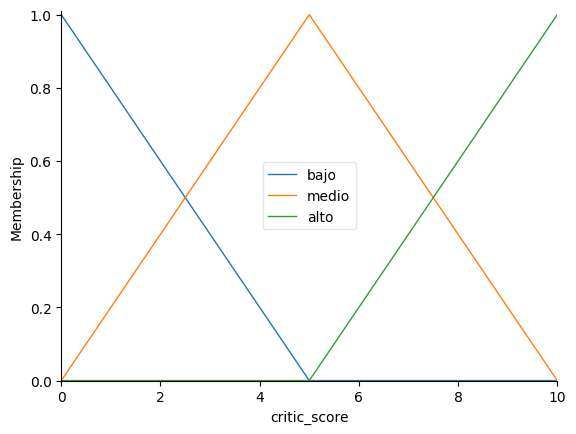

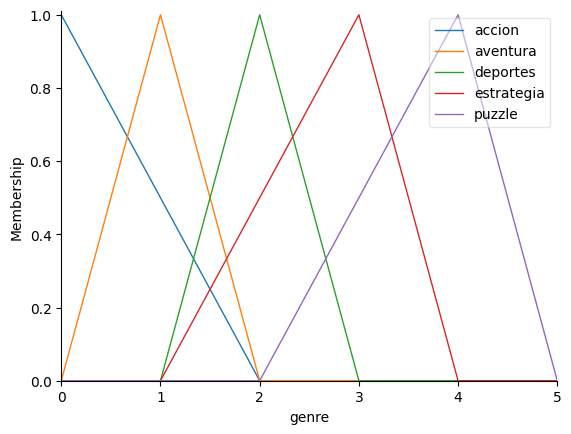

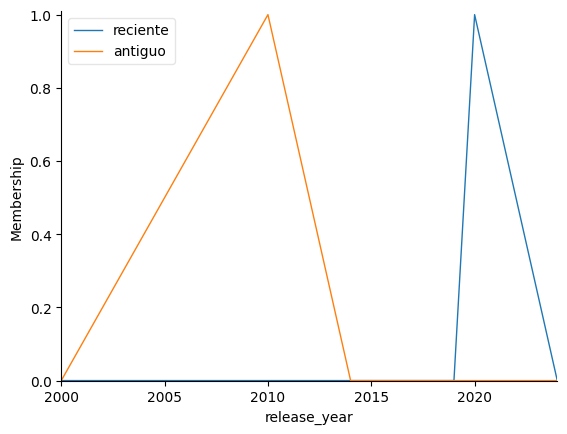

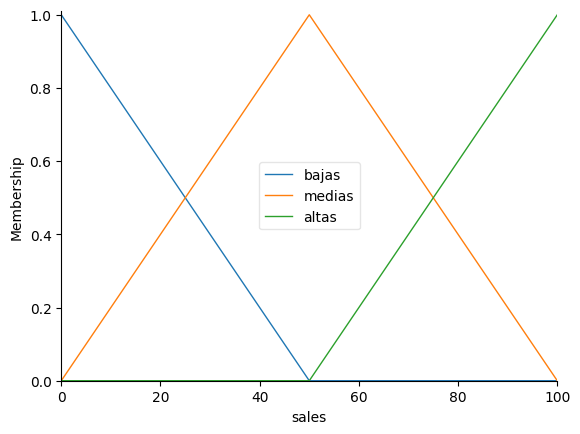

In [17]:
# Define fuzzy variables
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Defining fuzzy variables for the system
critic_score = ctrl.Antecedent(np.arange(0, 11, 1), 'critic_score')
genre = ctrl.Antecedent(np.arange(0, 6, 1), 'genre')  # 5 genres for simplicity (0 to 4)
release_year = ctrl.Antecedent(np.arange(2000, 2025, 1), 'release_year')
sales = ctrl.Consequent(np.arange(0, 101, 1), 'sales')

# Membership functions for critic_score (low, medium, high)
critic_score['bajo'] = fuzz.trimf(critic_score.universe, [0, 0, 5])
critic_score['medio'] = fuzz.trimf(critic_score.universe, [0, 5, 10])
critic_score['alto'] = fuzz.trimf(critic_score.universe, [5, 10, 10])

# Membership functions for genre (action, adventure, sports, etc.)
genre['accion'] = fuzz.trimf(genre.universe, [0, 0, 2])
genre['aventura'] = fuzz.trimf(genre.universe, [0, 1, 2])
genre['deportes'] = fuzz.trimf(genre.universe, [1, 2, 3])
genre['estrategia'] = fuzz.trimf(genre.universe, [1, 3, 4])
genre['puzzle'] = fuzz.trimf(genre.universe, [2, 4, 4])

# Membership functions for release_year (recent, old)
release_year['reciente'] = fuzz.trimf(release_year.universe, [2020, 2020, 2024])
release_year['antiguo'] = fuzz.trimf(release_year.universe, [2000, 2010, 2014])

# Membership functions for sales (low, medium, high)
sales['bajas'] = fuzz.trimf(sales.universe, [0, 0, 50])
sales['medias'] = fuzz.trimf(sales.universe, [0, 50, 100])
sales['altas'] = fuzz.trimf(sales.universe, [50, 100, 100])

# Visualize the membership functions for each fuzzy variable
critic_score.view()
genre.view()
release_year.view()
sales.view()

**Definir las Reglas Difusas**

In [18]:
# Define fuzzy rules for the system
rule1 = ctrl.Rule(critic_score['bajo'], sales['bajas'])
rule2 = ctrl.Rule(critic_score['medio'], sales['medias'])
rule3 = ctrl.Rule(critic_score['alto'], sales['altas'])
rule4 = ctrl.Rule(genre['accion'] & critic_score['alto'], sales['altas'])
rule5 = ctrl.Rule(genre['aventura'] & critic_score['bajo'], sales['bajas'])
rule6 = ctrl.Rule(genre['deportes'] & critic_score['alto'], sales['altas'])
rule7 = ctrl.Rule(release_year['reciente'] & critic_score['alto'], sales['altas'])
rule8 = ctrl.Rule(release_year['antiguo'] & critic_score['bajo'], sales['bajas'])
rule9 = ctrl.Rule(genre['accion'] & release_year['reciente'] & critic_score['alto'], sales['altas'])
rule10 = ctrl.Rule(genre['aventura'] & release_year['antiguo'] & critic_score['bajo'], sales['medias'])

# Create the control system with the defined rules
sales_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10])

# Create a simulation object to compute results
sales_sim = ctrl.ControlSystemSimulation(sales_ctrl)

**Realizar Predicciones con el Sistema Difuso**

In [19]:
# Run fuzzy inference system with examples to predict sales

# Example 1: Predict sales for a game with critic_score 8.0, genre 'action' (0), and recent release
sales_sim.input['critic_score'] = 8.0
sales_sim.input['genre'] = 0  # Action
sales_sim.input['release_year'] = 2023
sales_sim.compute()

print(f"Predicted sales for action game with critic_score 8.0 and recent release: {sales_sim.output['sales']}")

# Example 2: Predict sales for a game with critic_score 4.0, genre 'adventure' (1), and old release
sales_sim.input['critic_score'] = 4.0
sales_sim.input['genre'] = 1  # Adventure
sales_sim.input['release_year'] = 2010
sales_sim.compute()

print(f"Predicted sales for adventure game with critic_score 4.0 and old release: {sales_sim.output['sales']}")


Predicted sales for action game with critic_score 8.0 and recent release: 58.78048780487803
Predicted sales for adventure game with critic_score 4.0 and old release: 49.04761904761905
